<h1> <b>신뢰성 기반 수명 예측</b></h1>
&nbsp;

- <h3> <b>데이터 : <a href="https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/">[Turbofan Engine Degradation Simulation Data Set]</a></b></h3>

     - <h4> <b>train data : Run-to-Failure data</b> </h4>
     - <h4> <b>test data : Censored data</b> </h4> 
     <br>
- <h3> <b>확률분포</b></h3>

    - <h4> <b>와이블 분포</b></h4>
    
    - <h4> <b>지수 분포</b></h4>
    
    - <h4> <b>대수 정규 분포</b></h4>


In [392]:
options(warn = -1)

# 개인 함수 불러오기
src_dir = 'E:\\R\\prototype5\\function\\'
src_file = list.files(src_dir)
for(i in 1:length(src_file)) source(paste(src_dir, src_file[i], sep=''), encoding='utf-8')

In [527]:
# data import
# Train Dataset 
trainData = read.table('E:\\데이터\\예지보전\\CMAPSSData\\train_FD001.txt')
# testDataset 
testData = read.table('E:\\데이터\\예지보전\\CMAPSSData\\test_FD001.txt')

testRUL = read.table('E:\\데이터\\예지보전\\CMAPSSData\\RUL_FD001.txt')
testRUL = testRUL$V1
# column name 정의
colname = c()
for(i in 0:25){
  colname = append(colname, paste0('Section-',i))
}
colnames(trainData) = colname
colnames(testData) = colname

In [932]:
trainEoL = c()
for(machineNum in 1:100){
    trainEoL = append(trainEoL, nrow(trainData[trainData$'Section-0'== machineNum,]))
}
print(trainEoL)

  [1] 192 287 179 189 269 188 259 150 201 222 240 170 163 180 207 209 276 195
 [19] 158 234 195 202 168 147 230 199 156 165 163 194 234 191 200 195 181 158
 [37] 170 194 128 188 216 196 207 192 158 256 214 231 215 198 213 213 195 257
 [55] 193 275 137 147 231 172 185 180 174 283 153 202 313 199 362 137 208 213
 [73] 213 166 229 210 154 231 199 185 240 214 293 267 188 278 178 213 217 154
 [91] 135 341 155 258 283 336 202 156 185 200


In [933]:
# test data cycle 구하기
maxCycle = c()
for(machineNum in 1:100){
    maxCycle = append(maxCycle, sum(testData$'Section-0'==machineNum))
}
testEoL = testRUL + maxCycle
print(testEoL)

  [1] 143 147 195 188 189 198 251 261 166 288 180 341 290 153 159 197 215 161
 [19] 222 200 205 150 243 206 193 195 206 255 261 258 204 193 156 210 209 145
 [37] 142 175 179 161 141 166 231 163 266 193 208 170 324 153 258 218 190 218
 [55] 250 151 263 213 208 247 180 286 227 196 199 161 148 195 175 246 186 181
 [73] 243 263 201 215 196 179 164 223 221 171 210 230 152 199 172 183 313 174
 [91] 272 170 329 188 217 234 216 180 214 218


<h2><b> 확률분포 파라미터 추정 (MLE : Maximum Likelihood Estimation)</b></h2>

- <h3><b> 와이블 분포 파라미터 추정</b></h3>

In [417]:
library(stats4)

# Weibull
llh_weibull <- function(shape, scale){
  # log(likelihood) by summing 
  -sum(dweibull(x, shape, scale, log=TRUE))
}
x = trainEoL
fit_weibull <- mle(llh_weibull, start = list(shape=3, scale=1), method='L-BFGS-B')

In [934]:
# 와이블 분포의 파라미터
print(fit_weibull@coef)

     shape      scale 
  4.408716 225.025853 


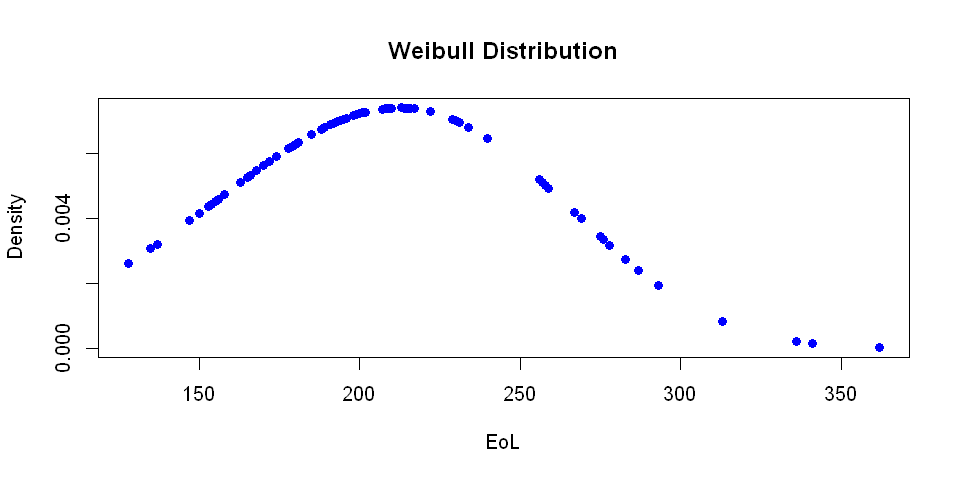

In [106]:
plot(x, dweibull(x, shape=fit_weibull@coef[1], scale=fit_weibull@coef[2]), pch=16, xlab='EoL', ylab='Density', col='blue')
title("Weibull Distribution")

- <h3><b> 지수 분포 파라미터 추정</b></h3>

In [395]:
# Exponential
x = trainEoL
# optimizer : "Nelder-Mead", "BFGS", "CG", "L-BFGS-B", "SANN"
llh_exp <- function(lambda){
  # log(likelihood) by summing 
  -sum(dexp(x, lambda, log=TRUE))
}
x = trainEoL

fit_exp <- mle(llh_exp, start = list(lambda=1), method='SANN')

In [935]:
# 지수 분포의 파라미터
print(fit_exp@coef)

     lambda 
0.004871476 


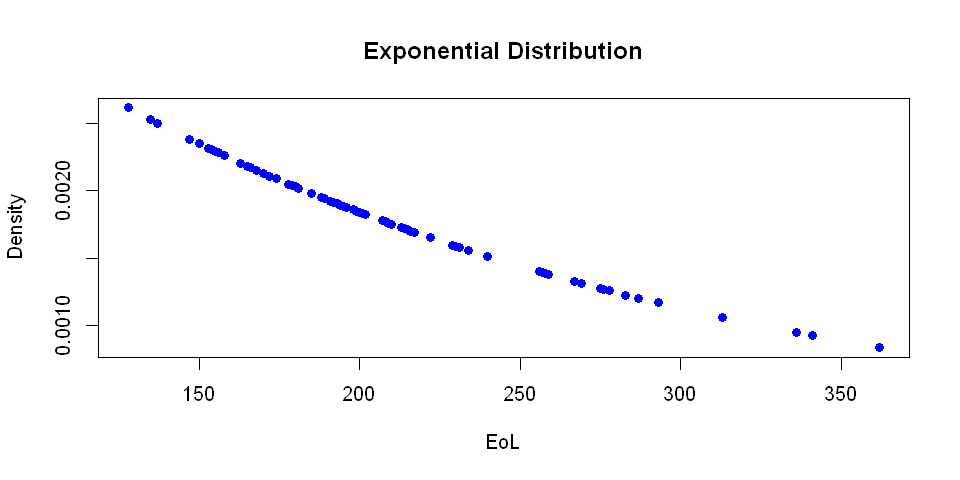

In [397]:
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow=c(1,1))
plot(x, dexp(x, fit_exp@coef), col='blue', pch=16, xlab='EoL', ylab='Density')
title("Exponential Distribution")

- <h3><b> 대수 정규분포 파라미터 추정</b></h3>

In [398]:
# Exponential
x = trainEoL
# optimizer : "Nelder-Mead", "BFGS", "CG", "L-BFGS-B", "SANN"
llh_lnorm <- function(mean, sd){
  # log(likelihood) by summing 
  -sum(dlnorm(x, mean, sd, log=TRUE))
}
x = trainEoL
fit_lnorm <- mle(llh_lnorm, start = list(mean=0, sd=1), method='SANN')

In [936]:
# 대수 정규 분포의 파라미터

# mu = mean(log(x))
# sigma = sd(log(x))
print(fit_lnorm@coef)

     mean        sd 
5.3060992 0.2109981 


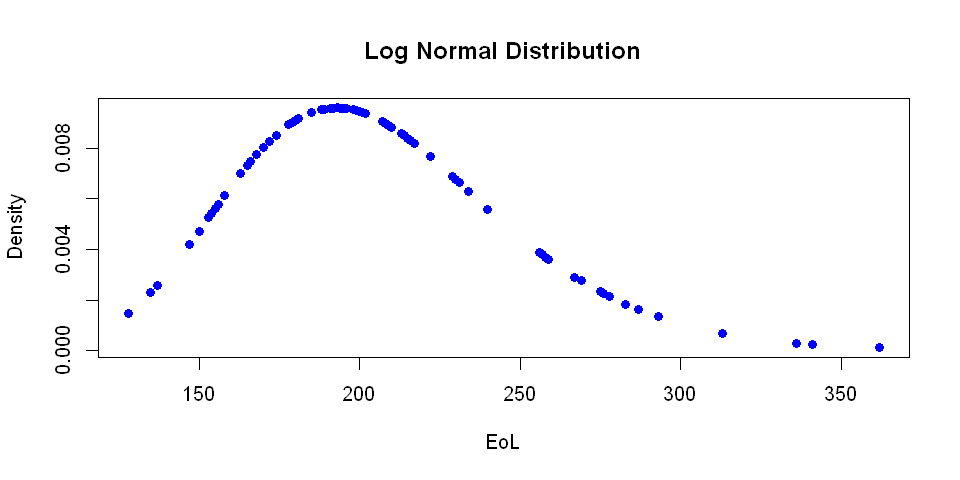

In [440]:
# Log Normal distribution
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow=c(1,1))
plot(x, dlnorm(x, fit_lnorm@coef[1], fit_lnorm@coef[2]), col='blue', pch=16, xlab='EoL', ylab='Density')
title("Log Normal Distribution")

<h2><b> 확률분포를 이용한 수명 추정</b></h2>

In [443]:
# Turbofan Engine Data
MTTF = mean(trainEoL)
sigma = sd(trainEoL)
sprintf('평균 : %f', MTTF)
sprintf('표준편차 : %f', sigma)

[1] "평균 : 206.310000"

[1] "표준편차 : 46.342749"

- <h3><b> 와이블 분포를 이용한 수명 추정</b></h3>

In [910]:
## Weibull (shape, scale), Exponential (lambda), Log-Normal(mean, sd)

# Reliability based RUL (MTTF)
RebRUL <- function(cycle=1:400, type='Weibull', ...){
    
    ## Rt : Reliability Function
    # Weibull
    if(type=='Weibull'){
        Rt <- function(x){
            exp(-(x/scale)^shape)
        }
    }
    # Exponential
    if(type=='Exponential'){
        Rt <- function(x){
            exp(-lambda*x)
        }
    }
    # Log Normal
#    if(type=='Log-Normal'){ # .한번 더 적분해야함
#        Rt <- function(x){
#            
#        }
#    }
   
    RUL = c()
    for(i in cycle){
        rul = integrate(Rt, lower=i, upper=Inf)
        RUL = append(RUL, rul$value)
    }
    return(RUL)
}

In [911]:
# Weibull distribution fit
shape = fit_weibull@coef[1]
scale=fit_weibull@coef[2]
weibull_RUL = RebRUL(cycle=1:400, type='Weibull')

In [912]:
# Exponential distribution fit
lambda = fit_exp@coef[1]
exp_RUL = RebRUL(cycle=1:400, type='Exponential')

In [913]:
# Log normal distribution fit
mean = fit_lnorm@coef[1]
sd = fit_lnorm@coef[2]
lnorm_RUL = RebRUL(cycle=1:400, type='Log-Normal')

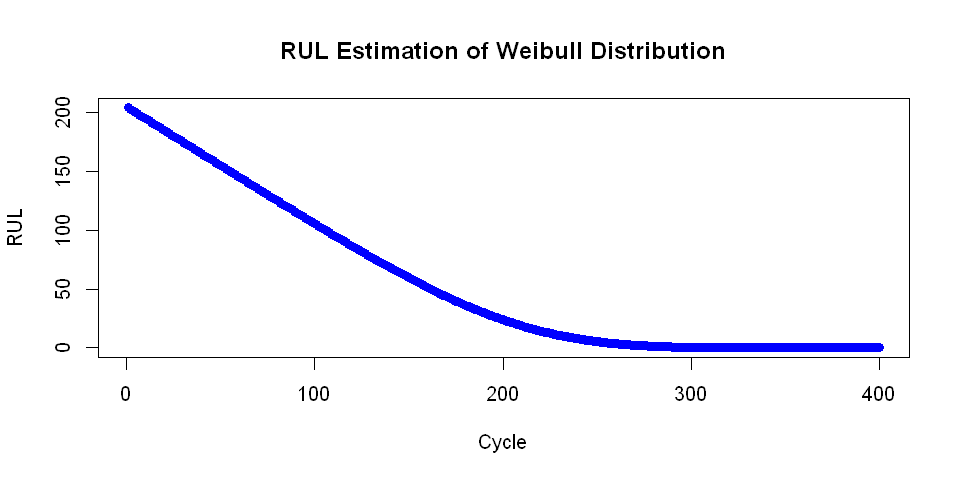

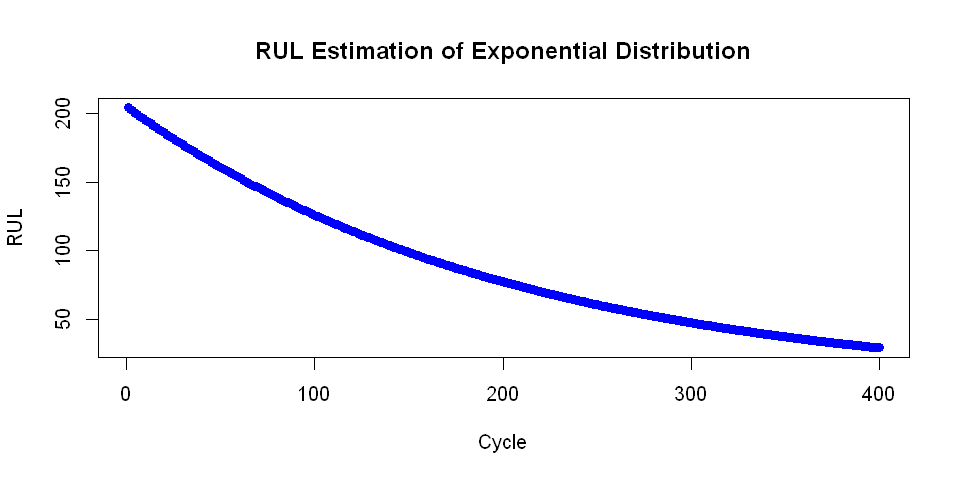

In [914]:
plot(weibull_RUL, xlab='Cycle', ylab='RUL', pch=16, col='blue')
title("RUL Estimation of Weibull Distribution")

plot(exp_RUL, xlab='Cycle', ylab='RUL', pch=16, col='blue')
title("RUL Estimation of Exponential Distribution")

#plot(lnorm_RUL, xlab='Cycle', ylab='RUL', pch=16, col='blue')
#title("RUL Estimation of Log-Normal Distribution")

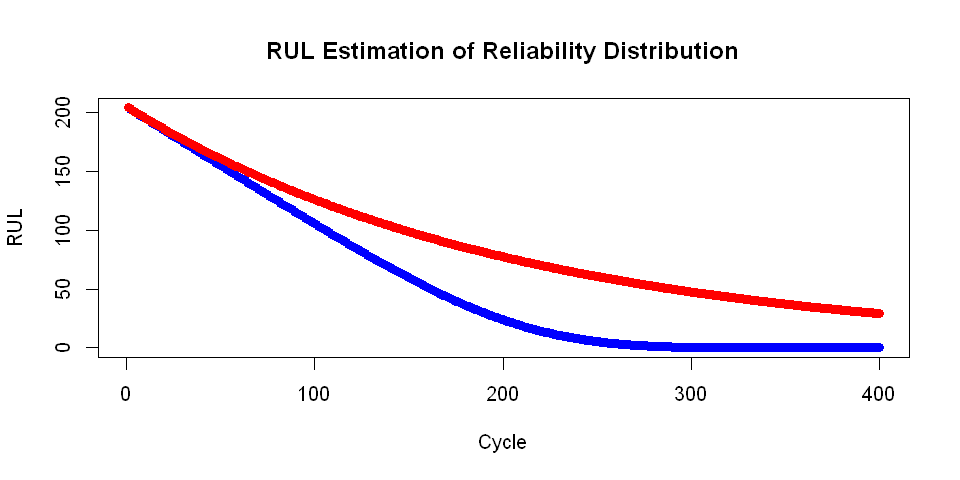

In [929]:
plot(weibull_RUL, xlab='Cycle', ylab='RUL', pch=16, col='blue')
points(exp_RUL,pch=16, col='red')
# points(lnorm_RUL,pch=16, col='green')
title('RUL Estimation of Reliability Distribution')
# legend(300, 200, c('Weibull', 'Exponential'), col=c('blue',' red'), pch=16, lty=1, box.lty=0, cex=1)

In [930]:
weibull_RUL = RebRUL(cycle=maxCycle, type='Weibull')
exp_RUL = RebRUL(cycle=maxCycle, type='Exponential')

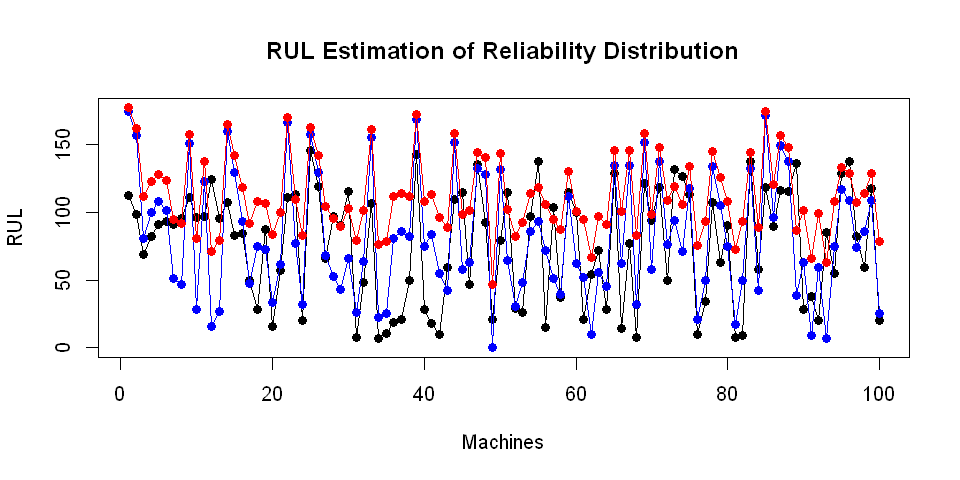

In [931]:
range = c(testRUL,weibull_RUL, exp_RUL)
plot(testRUL, col='black', pch=16, type='o', ylim=c(0,max(range)), xlab='Machines', ylab='RUL')
points(weibull_RUL, col='blue', pch=16, type='o')
points(exp_RUL, col='red', pch=16, type='o')
title('RUL Estimation of Reliability Distribution')
#legend('top',c('Weibull', 'Exponential'), col=c('blue',' red'), pch=16, lty=1, box.lty=1, cex=1)

<h2><b> 결론 </b></h2>

- <h4> 해당 script는 신뢰성 분포 기반 수명 예측을 목표로함 </h4>
- <h4> 신뢰성 분포로는 와이블분포, 지수분포, 대수정규분포를 사용 하였음 </h4>
- <h4> 신뢰성 분포의 파라미터는 MLE를 이용해 최적값을 추정하였음 </h4>
- <h4> 그 후, 추정된 수명분포를 이용하여 수명을 추정하였음 </h4>